# Procesamiento de Imagenes Satelitales Landsat 8 OLI LASRC

Las scenas **Landsat 8 OLI LASRC** tomadas en este trabajo, son imágenes pertenecientes a la Colección 1 - Nivel 2 (On demand) del catálogo de imagenes USGS Earth Explorer. Las imagenes del Nivel 2 presentan correcciones atmosfericas de reflectancia de superficie (Surface Reflectance SR). Estas correcciones mitigan el efecto de los gases o aerosoles que se encuentran en la atmosfera y pueden afectar la reflectancia de la tierra sensada por el satelite (sensor). Las correcciones atmosféricas son llevadas a cabo por el algoritmo LASRC (Landsat Surface Reflectance Code)

Durante la generación de las scenas corregidas en superficie de reflectancia, el algoritmo LASRC evalua la calidad de cada pixel y esta información la información de esta evaluación la registra en 3 bandas (**sr_aeroso**, **pixel_qa**, **radsat_qa**) que se generan de forma adicional al finalizar la corección de reflectancia.

El rango de valores que se pueden encontrar para cada pixel en las respectivas bandas son:

* band_1 (coastal_aerosol): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_2 (blue): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_3 (green): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_4 (red): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_5 (nir): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_6 (swir1): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* band_7 (swir2): unidad=reflectancia; rango=-2000,16000; rango_valido=0,10000
* pixel_qa (pixel_qa): rango=0,32768 rango_valido=0,32768 
* sr_aerosol (sr_aerosol_qa, aerosol_qa, aerosol): rango=0,255; rango_valido=0,255
* radsat_qa (radsat_qa): rango=0,32768 rango_valido=0,32768


## Referencias
1. [Designación de Bandas para Satelites Landsat](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites?qt-news_science_products=0#qt-news_science_products)
2. [Evaluación de la Calidad de los Pixeles en Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8-surface-reflectance-quality-assessment?qt-science_support_page_related_con=1#qt-science_support_page_related_con)
3. [Lansat Surface Reflectance Code (LASRC) Product Guide](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_SurfaceReflectanceCode-LASRC_ProductGuide-v2.pdf) - Cloud Mask

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import rasterio as rio

import os
import glob
import tarfile
import shutil
import datacube

from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask

In [8]:
dc = datacube.Datacube(app="Query")

xarr = dc.load(
    product="LS8_OLI_LASRC",
    latitude=(4,5),
    longitude=(-78, -77), 
    # Time format YYYY-MM-DD
    time=("2018-01-01","2018-01-31"), 
    measurements=['blue','green','red','swir1','swir2','pixel_qa']
)

xarr

<xarray.Dataset>
Dimensions:    (latitude: 3687, longitude: 3705, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-10T15:25:11
  * latitude   (latitude) float64 5.0 5.0 4.999 4.999 4.999 4.999 4.998 ...
  * longitude  (longitude) float64 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 -78.0 ...
Data variables:
    blue       (time, latitude, longitude) int16 297 299 301 301 299 305 311 ...
    green      (time, latitude, longitude) int16 162 157 156 159 159 168 168 ...
    red        (time, latitude, longitude) int16 65 66 66 64 63 71 74 75 71 ...
    swir1      (time, latitude, longitude) int16 32 30 30 31 33 33 35 37 35 ...
    swir2      (time, latitude, longitude) int16 24 21 21 25 27 25 27 27 24 ...
    pixel_qa   (time, latitude, longitude) int32 324 324 324 324 324 324 324 ...
Attributes:
    crs:      EPSG:4326

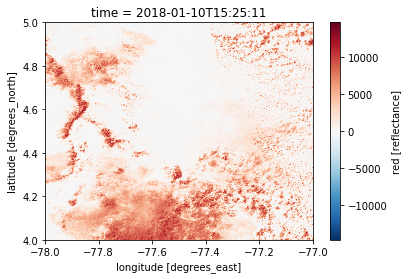

In [9]:
xarr.red.plot()

(array([8.536000e+03, 5.268473e+06, 1.726399e+06, 1.215810e+06,
        9.792200e+05, 7.110370e+05, 3.999030e+05, 9.343000e+04,
        8.883000e+03, 2.570000e+02]),
 array([-1607. ,    25.1,  1657.2,  3289.3,  4921.4,  6553.5,  8185.6,
         9817.7, 11449.8, 13081.9, 14714. ]),
 <a list of 10 Patch objects>)

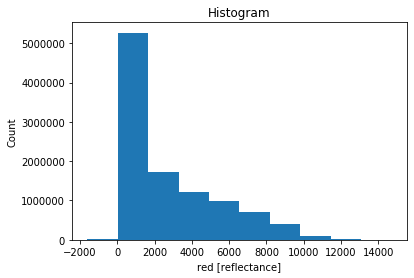

In [15]:
xarr.red.plot.hist()

## Mascara de Nubes

Las nubes y las condiciones atmosféricas presentan un desafío importante cuando se trabaja con datos de detección remota multiespectrales. Las nubes y sombras extremas pueden generar datos initilizables. En principio las nubes dispersan toda la luz emitida por el sol haciendo que regrese al sensor sin datos relevantes. Por otro lado, puede sucede que la luz sea absorvida o bloqueada en este caso la cantidad de datos sensado de la superficie terrestre también es irrelavante.

Las imagenes landsat con corrección de reflectancia vienen con unas capas de calidad (**pixel_qa**) que permiten detectar la presencia de nubes, sombra e incluso agua en el monitoreo. Esta capa nos permitira identiicar y eliminar los pixeles que no son utiles para el analisis.

### Referencias
1. [Clean Remote Sensing Data in Python - Clouds, Shadows & Cloud Masks](https://www.earthdatascience.org/courses/earth-analytics-python/multispectral-remote-sensing-modis/cloud-masks-with-spectral-data-python/)

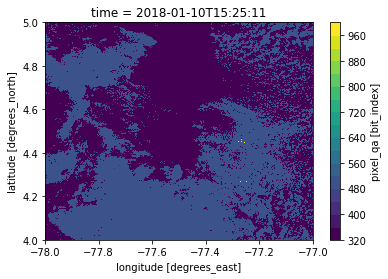

In [24]:
xarr.pixel_qa.plot(levels=20)

In [13]:
def cloud_mask(band_data_array,band_pixel_qa,product,nodata=-9999):

    # PIXEL_QA VALUES TO BE MASKED (IDEAM) 
    clear = [322, 386, 834, 898, 1346]
    water = [324, 388, 836, 900, 1348]
    mask_values = clear + water

    # PIXEL_QA VALUES TO BE MASKED (References)
    # clear = [322, 386, 834, 898, 1346]
    # cloud_shadow = [328, 392, 840, 904, 1350]
    # cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
    # high_confidence_cloud = [480, 992]
    # mask_values = clear + cloud_shadow + cloud + high_confidence_cloud

    # El valor True en la máscara indica que el pixel debe ser enmascarado
    # o removido porque no es válido para el análisis.El valor False en la 
    # máscara indica que el pixel es valido y no será removido
    mask_1 = np.isin(band_pixel_qa.values, mask_values)

    # Aquellos pixeles que no son iguales a nodata y además tiene
    # un valor de True en mask_1 deben ser marcados como True
    # en mask_2 para ser removidos.
    mask_2 = np.logical_and(band_data_array != nodata, mask_1)

    new_band_data_array = np.where(mask_2, band_data_array,nodata)
    return new_band_data_array

(array([8.536000e+03, 5.268473e+06, 1.726399e+06, 1.215810e+06,
        9.792200e+05, 7.110370e+05, 3.999030e+05, 9.343000e+04,
        8.883000e+03, 2.570000e+02]),
 array([-1607. ,    25.1,  1657.2,  3289.3,  4921.4,  6553.5,  8185.6,
         9817.7, 11449.8, 13081.9, 14714. ]),
 <a list of 10 Patch objects>)

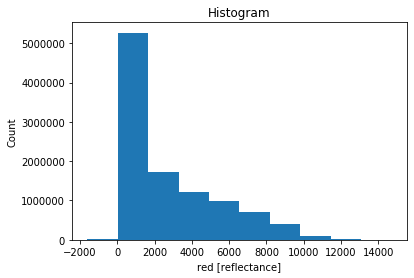

In [14]:
band_data_array.plot.hist()